# Qiskit Fall Fest @ Yonsei 2025 : Challenger Hackathon

> Welcome to the Qiskit Fall Fest @ Yonsei 2025 Challenger Hackathon! 🎉  
> This notebook is designed to provide a challenging and novel experience for those familiar with quantum computing and Qiskit.
> Once you complete everything, you'll be automatically entered into the challenger challenge prize draw, so take on the challenge and grab your chance at winning!

**How to Proceed:**

1.  **Learn the Concepts**: Read the explanations for each topic carefully.
2.  **Write Code**: In the cells below each explanation, write code that matches the problem where it says `TODO`.
3.  **Check Your Answer**: After writing your code, run the `Grader Cell` right below to check if your answer is correct.
4.  **Prize Entry**: Once you pass all problems up to the last one, you'll be automatically entered into the prize draw.

### GOOD LUCK 🤞

## Setup

First, run the cell below to install and import the packages needed for this challenge

In [10]:
pip install qiskit_addon_obp qiskit_addon_utils


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



     -------------------------------------- 44.9/44.9 kB 753.5 kB/s eta 0:00:00


In [11]:
! pip install 'qiskit[visualization]' qiskit-ibm-runtime qiskit-aer qiskit-addon-cutting qiskit-addon-obp qiskit-addon-utils
! pip install requests


import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler, EstimatorV2 as Estimator, QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit import Parameter
from scipy.optimize import minimize

from qiskit.primitives import StatevectorEstimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap
from qiskit.synthesis import LieTrotter

from qiskit_addon_obp import backpropagate
from qiskit_addon_obp.utils.simplify import OperatorBudget
from qiskit_addon_obp.utils.truncating import setup_budget

from qiskit_addon_utils.problem_generators import (
    generate_xyz_hamiltonian,
    generate_time_evolution_circuit,
)
from qiskit_addon_utils.slicing import slice_by_gate_types, combine_slices


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions,
)
from qiskit_aer import AerSimulator


import qff25_yonsei_challenger_grader as grader

ERROR: Invalid requirement: "'qiskit[visualization]'"

[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
# Initialize grader

user_name = "Fyodor_2073"
grader.initialize_grader(user_name)

    QISKIT FALL FEST @ YONSEI 2025 Challenger Hackathon에 오신것을 환영합니다!
    지금부터 Fyodor_2073님의 채점 현황이 기록됩니다.


In [15]:
# Check that the account has been saved properly
service = QiskitRuntimeService()
service.saved_accounts()

{'qff25-ys': {'channel': 'ibm_quantum_platform',
  'url': 'https://cloud.ibm.com',
  'token': 'rYQEiSqNTywCTlDhavJZmwKCTtILh0cGXXcmUCKvXial',
  'instance': 'crn:v1:bluemix:public:quantum-computing:us-east:a/61646611da77493991cc1c14cf494f3b:7884cb23-af4d-4e2e-a7da-35814068d79e::',
  'verify': True,
  'private_endpoint': False}}

---
## Part 1. Operator Backpropagation

**Operator Backpropagation (OBP)** is a technique that absorbs the operations in the latter part of a quantum circuit into the observable to be measured. This process generally reduces the depth of the circuit executed on quantum hardware at the cost of increasing the number of terms in the observable.

This process typically involves a trade-off where the benefit of reduced circuit depth comes at the expense of increased term count in the observable. That's why techniques like Truncation are used together with it.

* #### Background
The expectation value we want to obtain through the `Estimator` primitive is expressed as $\langle O\rangle_{U|\psi\rangle} = \langle\psi|U^\dagger OU|\psi\rangle$ for the initial state $|\psi\rangle$ and the entire circuit $U$.

We split the entire circuit $U$ into a front part ($U_Q$) to be executed on the quantum computer and a back part ($U_C$) to be calculated classically. ($U=U_C U_Q$) Substituting this into the above expectation value equation gives: $\langle O \rangle_{U|\psi\rangle} = \langle\psi|(U_CU_Q)^\dagger O (U_C U_Q)|\psi\rangle = \langle\psi|U_Q^\dagger(U_C^\dagger O U_C)U_Q|\psi\rangle$

Here, if we define $U_C^\dagger O U_C$ inside the parentheses as a new observable $O'$, we get $\langle \psi|U_Q^\dagger O' U_Q |\psi\rangle$. 

Simulating the effect of quantum circuit $U_C$ on a quantum 'state' with a classical computer is difficult. However, the $U_C^\dagger O U_C$ operation deals with the 'operator' itself rather than the 'state', so it can be calculated efficiently on a classical computer.

(The $U_C^\dagger O U_C$ operation can be calculated efficiently by tracking how each Pauli term composing $O$ changes as it passes through the gates of $U_C$ according to Pauli algebra rules, instead of directly multiplying huge matrices.)

As a result, the original problem of calculating $\langle O\rangle_{U|\psi\rangle}$ is transformed into the problem of measuring the expectation value of a more complex observable $O'$ for the circuit $U_Q$ with reduced depth, namely $\langle O' \rangle_{U_Q|\psi\rangle}$.

* #### Truncation

By using OBP to reduce the depth of $U_Q$ and gain benefits, there's a trade-off where the number of terms in the new observable $O'$ to be measured increases, leading to increased classical post-processing computation and total measurement count.

To balance this trade-off, we can use **Truncation**, which discards terms with very small coefficients from the terms in $O'$. Truncation can reduce the number of measurements, but at the cost of introducing error in the results.

Therefore, it's important to appropriately adjust the truncation level to find a balance between the noise reduction effect from circuit depth reduction and the error from truncation.

* #### Clifford Perturbation Theory 

The `qiskit-addon-obp` package implements OBP based on Clifford perturbation theory.

Quantum gates can be divided into Clifford gates, which are easy to simulate classically, and Non-Clifford gates, which are difficult.
* Clifford gates (ex. X, H, S, CNOT): Operations are relatively simple, so they have low computational cost to backpropagate. Therefore, they hardly increase the complexity of the observable.

* Non-Clifford gates (ex. T, rotational gates): When these gates are backpropagated, the number of terms in the observable greatly increases, making the computational cost for classical computers high.

This approach has the advantage that the overhead from backpropagation is proportional to the non-Cliffordness of $U_C$ (how much $U_C$ consists of non-Clifford gates). That is, if $U_C$ consists of Clifford gates, OBP can be performed faster and more efficiently.

This method slices $U_C$ as $U_C = \prod_{s=1}^S u_s=u_s...u_2u_1$ and backpropagates each slice one by one, continuously tracking how complex the new observable $O'$ becomes.

If $O'$ becomes too complex or the error from backpropagation seems likely to exceed the preset error budget, truncation is performed.

---
The core of the `qiskit-addon-obp` package is the `backpropagate()` function. This function cuts out part of a long quantum circuit, replaces it with classical computation, and produces a shorter circuit and a more complex observable as a result.

The usage of the `backpropagate()` function is broadly as follows:

##### 1. Problem Definition

First, define the physical system to simulate and the observable.

* Hamiltonian: Define the Hamiltonian of the system to simulate.

* Observable: Define the observable to measure.
For the above example, it can be set as $\langle Z_0 \rangle$.

* Entire circuit ($U$): The entire quantum circuit representing how the system changes over a specific time according to the Hamiltonian.


##### 2. Defining Circuit Slices and Error Budget

Next, we need to determine two important elements for applying OBP:

* Circuit Slice: Cut the back part $U_C$ to be backpropagated from the entire circuit $U$ into a list of small circuit pieces (slices).

* Error Budget: Set rules to control the observable from becoming excessively complex during the backpropagation process.
    * `TruncationErrorBudget`: Maximum allowable theoretical error
    * `OperatorBudget`: Maximum number of terms the final observable can have

##### 3. Executing the `backpropagate()` Function

Now pass the arguments prepared above to the `backpropagate()` function to execute it.

* Input: Original Observable ($O$), $U_C$, Error Budget

* Output: New Observable ($O'$), $U_Q$


##### 4. Calculating Expectation Value

Finally, use the `Estimator` primitive to calculate the expectation value of the results obtained in step 3. 

`Estimator.run(circuits=U_Q, observables=O')`

---
Now let's use the `qiskit-addon-obp` package following the above steps.

Let's efficiently simulate the time evolution of a Heisenberg XYZ chain using OBP.

### **Problem 1-1:**

Write code that performs the following:

Form a linear chain of **10** qubits using `CouplingMap`.

In [18]:
num_qubits = 10

layout = [(i-1, i) for i in range(1, num_qubits)]
coupling_map = CouplingMap(layout)

In [19]:
# Grader Cell
grader.grade_1_1(coupling_map)

🎉축하합니다! 정답입니다! 다음 문제로 넘어가세요


---
Next, generate a Pauli operator that models the Heisenberg XYZ Hamiltonian based on the `coupling_map`.

### **Problem 1-2**

$${\hat{\mathcal{H}}_{XYZ} = \sum_{(j,k)\in E} (J_{x} \sigma_j^{x} \sigma_{k}^{x} + J_{y} \sigma_j^{y} \sigma_{k}^{y} + J_{z} \sigma_j^{z} \sigma_{k}^{z}) + \sum_{j\in V} (h_{x} \sigma_j^{x} + h_{y} \sigma_j^{y} + h_{z} \sigma_j^{z})}$$

Where the interaction term coefficients are $${J = (J_x, J_y, J_z) = (\frac{\pi}{8}, \frac{\pi}{4}, \frac{\pi}{2})}$$, and the external magnetic field term coefficients are $${h = (h_x, h_y, h_z) = (\frac{\pi}{3}, \frac{\pi}{6}, \frac{\pi}{9})}$$.

From this generated Hamiltonian, create a quantum circuit that simulates the dynamics over **time ($t=0.2$)**.

Approximate the time evolution using Lie-Trotter decomposition with 2 Trotter steps (`reps=2`).

SparsePauliOp(['IIIIIIIXXI', 'IIIIIIIYYI', 'IIIIIIIZZI', 'IIIIIXXIII', 'IIIIIYYIII', 'IIIIIZZIII', 'IIIXXIIIII', 'IIIYYIIIII', 'IIIZZIIIII', 'IXXIIIIIII', 'IYYIIIIIII', 'IZZIIIIIII', 'IIIIIIIIXX', 'IIIIIIIIYY', 'IIIIIIIIZZ', 'IIIIIIXXII', 'IIIIIIYYII', 'IIIIIIZZII', 'IIIIXXIIII', 'IIIIYYIIII', 'IIIIZZIIII', 'IIXXIIIIII', 'IIYYIIIIII', 'IIZZIIIIII', 'XXIIIIIIII', 'YYIIIIIIII', 'ZZIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIIY', 'IIIIIIIIIZ', 'IIIIIIIIXI', 'IIIIIIIIYI', 'IIIIIIIIZI', 'IIIIIIIXII', 'IIIIIIIYII', 'IIIIIIIZII', 'IIIIIIXIII', 'IIIIIIYIII', 'IIIIIIZIII', 'IIIIIXIIII', 'IIIIIYIIII', 'IIIIIZIIII', 'IIIIXIIIII', 'IIIIYIIIII', 'IIIIZIIIII', 'IIIXIIIIII', 'IIIYIIIIII', 'IIIZIIIIII', 'IIXIIIIIII', 'IIYIIIIIII', 'IIZIIIIIII', 'IXIIIIIIII', 'IYIIIIIIII', 'IZIIIIIIII', 'XIIIIIIIII', 'YIIIIIIIII', 'ZIIIIIIIII'],
              coeffs=[0.39269908+0.j, 0.78539816+0.j, 1.57079633+0.j, 0.39269908+0.j,
 0.78539816+0.j, 1.57079633+0.j, 0.39269908+0.j, 0.78539816+0.j,
 1.57079633+0.j, 0.39269908+0.j, 0.

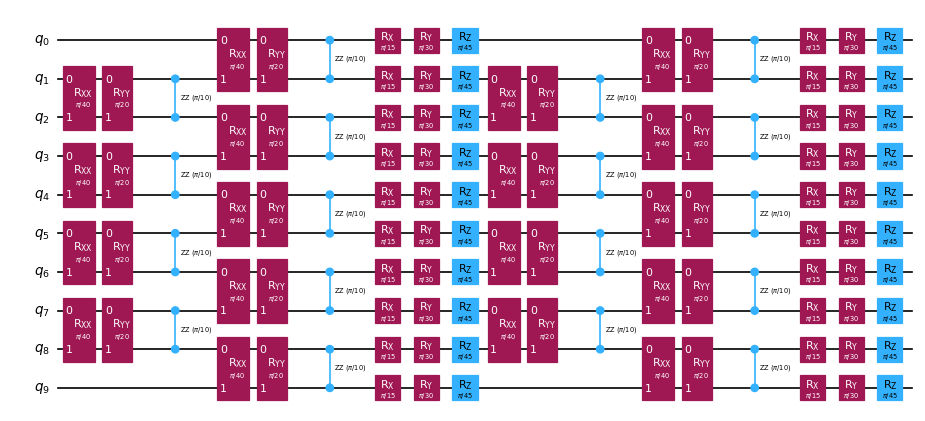

In [23]:
hamiltonian = generate_xyz_hamiltonian(
    coupling_map,
    coupling_constants= [np.pi/8, np.pi/4, np.pi/2] ,
    ext_magnetic_field= [np.pi/3, np.pi/6, np.pi/9] ,
)
print(hamiltonian)

circuit = generate_time_evolution_circuit(
    hamiltonian,
    time= 0.2 ,
    synthesis= LieTrotter(2),
)

circuit.draw("mpl", style="iqp", scale=0.6)

In [24]:
# Grader Cell
grader.grade_1_2(hamiltonian, circuit)

🎉축하합니다! 정답입니다! 다음 문제로 넘어가세요


---

### **Problem 1-3**
Set the Observable as $O = \frac{1}{N} \sum X_i $.

Create `observable` using `SparsePauliOp`.


In [27]:
observable = SparsePauliOp.from_sparse_list(
    [("X", [i], 1/num_qubits) for i in range(num_qubits)],
    num_qubits=num_qubits
)
print(observable)

SparsePauliOp(['IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j, 0.1+0.j,
 0.1+0.j, 0.1+0.j])


In [28]:
# Grader Cell

grader.grade_1_3(observable)

🎉축하합니다! 정답입니다! 다음 문제로 넘어가세요


---

Now let's prepare the input data for `backpropagate()` - circuit slices and error budget - and execute it.

### **Problem 1-4:**

Write code that performs the following:

1. Slice `circuit` using `slice_by_gate_types()`.

* Note: The performance of backpropagation varies greatly depending on how the circuit is sliced. `slice_by_gate_types` is a method that groups similar types of gates together for slicing (e.g., RZ gates together, CX gates together, etc.).

2. Use `OperatorBudget()` to create an `op_budget` variable so that the number of terms (QWC groups) in the backpropagated observable does not exceed 8.

3. Use `setup_budget()` to set the allowable theoretical error when backpropagating each slice to 0.05, and create a `trunc_budget` variable.

4. Use `combine_slices` to recombine the remaining slices that couldn't be backpropagated into the new observable to create $U_Q$.

Separated the circuit into 18 slices.

Backpropagated 10 slices.
The original observable had 10 terms.
New observable has 106 terms, which can be combined into 10 groups.
After truncation, the error in our observable is bounded by 4.767e-02
The remaining circuit after backpropagation(U_Q) looks as follows:


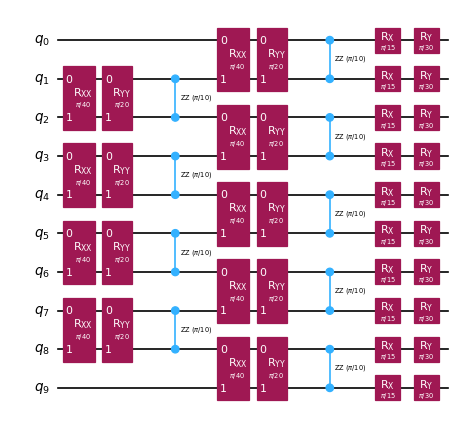

In [42]:
slices = slice_by_gate_types(circuit)
print(f"Separated the circuit into {len(slices)} slices.\n")

op_budget = OperatorBudget(max_qwc_groups=10)
trunc_budget = setup_budget(max_error_per_slice=0.005)

bp_observable, remaining_slices, metadata = backpropagate(
    observable,
    slices,
    operator_budget=op_budget,
    truncation_error_budget=trunc_budget,
)
bp_circuit = combine_slices(remaining_slices)

print(f"Backpropagated {metadata.num_backpropagated_slices} slices.")
print(f"The original observable had {len(observable.paulis)} terms.")
print(
    f"New observable has {len(bp_observable.paulis)} terms, which can be combined into {len(bp_observable.group_commuting(qubit_wise=True))} groups."
)
print(
    f"After truncation, the error in our observable is bounded by {metadata.accumulated_error(0):.3e}"
)
print("The remaining circuit after backpropagation(U_Q) looks as follows:")
bp_circuit.draw("mpl", scale=0.6)

In [43]:
# Grader Cell
grader.grade_1_4(bp_observable, bp_circuit, observable, circuit)

🎉축하합니다! 정답입니다! 다음 문제로 넘어가세요


#### Comparing the circuit results from Problem 1 and Problem 2, you can confirm that the circuit ($U_Q$) that actually needs to run on the quantum computer has become much shorter.
---

#### Now let's calculate the expectation value with the circuit and observable after OBP, and compare it with the actual expectation value.

Calculate the actual expectation value with `StatevectorEstimator`.

In [44]:
ideal_estimator = StatevectorEstimator()

result_exact = ideal_estimator.run([(circuit, observable)]).result()[0].data.evs.item()
print(f"Exact expectation value: {result_exact}")

Exact expectation value: 0.27897209752030405


Check the expectation value in the noisy simulator.

In [46]:
service = QiskitRuntimeService(name="YOUR_INSTANCE_NAME")
backend = service.least_busy()
backend_sim = AerSimulator.from_backend(backend)

AccountNotFoundError: 'Account with the name YOUR_INSTANCE_NAME does not exist on disk.'

In [47]:
pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=3)

circuit_isa = pm.run(circuit)
observable_isa = observable.apply_layout(circuit_isa.layout)

bp_circuit_isa = pm.run(bp_circuit)
bp_obs_isa = bp_observable.apply_layout(bp_circuit_isa.layout)

NameError: name 'backend_sim' is not defined

In [ ]:
options = EstimatorOptions()
options.default_precision = 0.011
options.resilience_level = 2

estimator = Estimator(mode=backend_sim, options=options)

pub = (circuit_isa, observable_isa)
bp_pub = (bp_circuit_isa, bp_obs_isa)

job = estimator.run([pub, bp_pub])

result_no_bp = job.result()[0].data.evs.item()
result_bp = job.result()[1].data.evs.item()

std_no_bp = job.result()[0].data.stds.item()
std_bp = job.result()[1].data.stds.item()


print(f"Expectation value without backpropagation: {result_no_bp} ± {std_no_bp}")
print(f"Backpropagated expectation value: {result_bp} ± {std_bp}")

Compare and check the actual value with results before and after OBP application and with truncation applied.

In [ ]:
methods = [
    "No backpropagation",
    "Backpropagation",
]
values = [result_no_bp, result_bp]
stds = [std_no_bp, std_bp]

ax = plt.gca()
plt.bar(methods, values, color="#a56eff", width=0.4, edgecolor="#8a3ffc")
plt.axhline(result_exact)
ax.set_ylim([0.20, 0.30])
plt.text(0.2, 0.285, "Exact result")
ax.set_ylabel(r"$M_X$", fontsize=12)

---
## Optimal OBP Budget

When using OBP, the OperatorBudget is an important parameter that balances between result accuracy and computational cost. However, it's difficult to know in advance how the complexity of the observable (number of QWC groups) will increase during the backpropagation process.

In this problem, by analyzing the `metadata` information obtained from running the `backpropagate()` function, we'll find out all the actually possible QWC group numbers within a given maximum limit (`max_n`), and complete a function that creates `OperatorBudget` objects corresponding to them.

This will later be used to efficiently compare the effects of OBP under various budget settings.

### **Problem 1-5:**

Complete the `all_op_budget(slices, max_n)` function that performs the following:

1. Run OBP with maximum budget: Get `metadata` with `backpropagate(max_qwc_groups=max_n)`.

2. Get QWC groups: Iterate through `metadata.backpropagation_history` and extract the `num_qwc_groups` recorded at each backpropagation step, storing them in `max_qwc_groups_list`.

3. Organize results: 
* Remove duplicate values from `max_qwc_groups_list` and sort in ascending order.

* For each QWC group number (`i`) in the sorted list, create an `OperatorBudget(max_qwc_groups=i)` object to build the `op_budgets` list.

* Return the `op_budgets` list and `max_qwc_groups_list`.

In [54]:
def all_op_budget(slices: list, max_n: int):
    bp_observable, remaining_slices, metadata = backpropagate(
        observable, 
        slices, 
        operator_budget=OperatorBudget(max_qwc_groups=max_n), 
    )

    # Extract num_qwc_groups from each backpropagation step
    max_qwc_groups_list = [i.num_qwc_groups for i in metadata.backpropagation_history]
    
    # Remove duplicates and sort in ascending order
    max_qwc_groups_list = sorted(list(set(max_qwc_groups_list)))
    
    # Create OperatorBudget objects for each QWC group number
    op_budgets = [OperatorBudget(max_qwc_groups=i) for i in max_qwc_groups_list]

    return op_budgets, max_qwc_groups_list

def all_op_budget(slices: list, max_n: int):
    bp_observable, remaining_slices, metadata = backpropagate(
        observable, 
        slices, 
        operator_budget=OperatorBudget(max_qwc_groups=max_n), 
    )

    max_qwc_groups_list = sorted(list(set(max_qwc_groups_list)))
    op_budgets = [OperatorBudget(max_qwc_groups=i) for i in max_qwc_groups_list]

    return op_budgets, max_qwc_groups_list

In [55]:
slices = slice_by_gate_types(circuit)
print(type(slices))
print(f"Separated the circuit into {len(slices)} slices.")

optimal_op_budgets, qwc_list = all_op_budget(slices, max_n=50)

print(f"Optimial Budgets: {optimal_op_budgets}")
print(f"QWC Groups: {qwc_list}")

<class 'list'>
Separated the circuit into 18 slices.


UnboundLocalError: local variable 'max_qwc_groups_list' referenced before assignment

Using this, we define a function for estimator execution with the circuit's slices and max_n as follows.

In [ ]:
def make_pubs(slices, observable, pm, max_n):
    op_budgets, _ = all_op_budget(slices, max_n)
    pubs = []
    for op_budget in op_budgets:
        bp_observable, remaining_slices, metadata = backpropagate(
            observable,
            slices,
            operator_budget=op_budget,
        )
        bp_circuit = combine_slices(remaining_slices)

        bp_circuit_isa = pm.run(bp_circuit)
        bp_observable_isa = bp_observable.apply_layout(bp_circuit_isa.layout)
        pubs.append((bp_circuit_isa, bp_observable_isa))

    return pubs


# This may take a long time.
pubs = make_pubs(slices, observable, pm, max_n=50)
job = estimator.run(pubs)

In [ ]:
# This may take a long time. (approximately 10 minutes)
results = [i.data.evs.item() for i in job.result()]
print(results)

Then plot the results as a graph to check.

In [ ]:
methods = [f"{i}" for i in qwc_list]

ax = plt.gca()
plt.bar(methods, results, color="#a56eff", width=0.4, edgecolor="#8a3ffc")
plt.axhline(result_exact)
ax.set_ylim([0.20, 0.30])
plt.text(0.2, 0.285, "Exact result")
ax.set_xlabel("Max qwc groups", fontsize=12)
ax.set_ylabel(r"$M_X$", fontsize=12)

---
<br><br><br>

---
## Part 2. Bomb Detector

Imagine there are bombs so sensitive that even a single ray of light would make them explode. Some of these are real working bombs, and some are defective.

Your mission is to identify only the real working bombs without detonating them.

This seems impossible with classical methods. To check, you have to touch it, and if you touch it, it explodes!

But using quantum mechanical principles, we can solve this paradoxical problem. This is the Elitzur-Vaidman bomb detector.

(For a more detailed explanation, refer to this YouTube video: https://www.youtube.com/watch?v=DNKp4QWc0Ys)

<img src="img/MZ.png" width="40%">

Quantum particles (photons) behave like waves, and when in a superposition state, they can act as if they're traveling along multiple paths simultaneously.

This experiment uses a device called a Mach-Zehnder Interferometer. It splits a photon into two paths and then recombines them to observe interference effects.

1. The first beam splitter creates a superposition state where the photon simultaneously travels along two different paths.
2. We place the bomb we want to check on one of the two paths (for convenience of explanation, we'll use the lower path).
3. The second beam splitter recombines the two paths, causing interference.


#### - Case 1) When there's no bomb (when the bomb is defective)

Detector 1: Destructive interference occurs where the waves from the lower and upper paths exactly cancel each other out, so no light reaches it and the photon is not detected at Detector 1.

Detector 2: Constructive interference occurs where the waves from the lower and upper paths perfectly amplify each other, so light reaches it and the photon is detected at Detector 2.

#### - Case 2) When there's a bomb

Bomb explodes: No detector goes off. The bomb actually exploded.

Detector 2 goes off: If Detector 2 went off even though there was a bomb, the photon luckily went along the upper path (safe path), avoided explosion, and Detector 2 might have been detected by chance in a state where interference was broken.

Detector 1 goes off: If there were no bomb, nothing should be detected in the Detector 1 direction due to destructive interference.

However, if it was detected at Detector 1, it means the destructive interference was destroyed by something, and what destroyed that interference was the bomb. --> We detected the bomb without detonating it! 😃

#### Therefore, this experiment has three possible outcomes:

1. Bomb explodes: The photon 'chooses' the path with the bomb, directly interacts with it, and it explodes. (Failure)

2. Bomb detected: The photon 'chose' the safe path without the bomb, but due to the aftermath of the broken superposition, it goes to Detector 1 where it didn't go before. This result gives 100% certainty of the bomb's existence without detonating it. (Success)

3. Unknown: Detector 2 might have gone off because there was actually no bomb, or there was a bomb but the photon chose the safe path and Detector 2 went off. This attempt gained no information.
---
#### First, let's implement the Mach-Zehnder interferometer as a quantum circuit in a situation where there's no bomb.

* Beam Splitter: A device that splits or combines a photon into two paths with 50% probability. This can be implemented in a quantum circuit with a Hadamard gate.

* Qubits: We use two qubits.

    1. q0: Represents the photon's path information.

    2. q1: Used to distinguish the two paths or create entanglement.

* Classical bit: One is needed to store the final result.

### **Problem 2-1:**

Create a make_no_bomb_circuit() function that performs the following:

1. Create a `QuantumCircuit` with 2 qubits and 1 classical bit.

2. First beam splitter:

    - Apply a Hadamard gate to q0 to create a superposition state.

    - Apply a CNOT(CX) gate with q0 as the control qubit and q1 as the target qubit.

    - Add `qc.barrier()` for readability.

3. Second beam splitter:

    - Apply a CNOT(CX) gate with q0 as the control qubit and q1 as the target qubit.

    - Apply a Hadamard gate to q0 to recombine the paths and cause interference.

    - Add `qc.barrier()` for readability.

4. Measure qubit q0 and store the result in classical bit 0.

In [ ]:
def make_no_bomb_circuit():
    # TODO

In [ ]:
# Grader Cell
grader.grade_2_1(make_no_bomb_circuit())

---

### **Problem 2-2:**

Use `AerSimulator` as the backend and run `no_bomb_circuit` with `Sampler` at `shots=1024` to obtain a histogram.

In [ ]:
# TODO

no_bomb_circuit = # TODO
# TODO
counts_no_bomb = # TODO

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
no_bomb_circuit.draw("mpl", ax=axes[0])
plot_histogram(counts_no_bomb, ax=axes[1])
plt.show()

In [ ]:
# Grader Cell
grader.grade_2_2(counts_no_bomb)

#### Since there was no bomb, everything was detected at Detector 2. (If the measurement result is 0, Detector 2 went off; if 1, Detector 1 went off.)
---
#### Now let's implement a quantum circuit for a situation where a working bomb is placed in the middle of the Mach-Zehnder interferometer path.

**Key idea: Bomb = Measurement**

In the Elitzur-Vaidman bomb detector, the bomb **checks** whether a photon passes through its path. In quantum mechanics, this **checking** action corresponds to **measurement**.

Therefore, placing a bomb in the middle of the circuit can be perfectly modeled by `measure()`ing the qubit passing through that path in the middle. This `measure()` operation is the key to simulating the bomb's presence and interaction.

### **Problem 2-3:**

Create a make_bomb_circuit() function that performs the following:

1. Create a `QuantumCircuit` with 2 qubits and 2 classical bits. (`c0` is for the final result, `c1` is a register for explosion status.)

2. First beam splitter:

    - Same as the previous problem (`make_no_bomb_circuit()`), superpose `q0` and entangle it with `q1` using H gate and CX gate.
    - Add `qc.barrier()` with `label='BOMB'` to mark the spot where the bomb will be.

3. Bomb:

    - Measure `q1` and store the result in `c1`. This models the bomb's presence.

    - Add qc.barrier() for readability.

4. Second beam splitter: Same as the previous problem, recombine the paths using CX gate and H gate. Add `qc.barrier()`.

5. Final measurement: Measure qubit `q0` and store the result in `c0`.

In [ ]:
def make_bomb_circuit():
    # TODO

In [ ]:
# Grader Cell
grader.grade_2_3(make_bomb_circuit())


#### Now let's run the circuit with the bomb and interpret the results.

The bomb detector circuit stores results in two classical bits (c1, c0).

- `c1`: Measurement result of `q1`. If `c1=1`, it means the bomb exploded.

- `c0`: Measurement result of `q0`. If `c0=0`, the photon was detected at Detector 2, and if `c0=1`, it means the bomb was successfully detected without detonation (Detector 1 detection).

### **Problem 2-4:**

Complete code that performs the following:

1. Use `AerSimulator` as the backend and run `bomb_circuit` with `Sampler` at `shots=1024`.

2. Add the count number to the `interpreted_counts` dictionary according to the results of `c0` and `c1`.
    - `'detected w/o exploding'`: When the bomb was successfully detected without detonation
    - `'exploded'`: When the bomb exploded
    - `'NA'`: When nothing happened

4. Draw a histogram of `interpreted_counts`.

In [ ]:
bomb_circuit = # TODO
# TODO

interpreted_counts = {"detected w/o exploding": 0, "exploded": 0, "NA": 0}

# TODO

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
bomb_circuit.draw("mpl", ax=axes[0])
plot_histogram(interpreted_counts, ax=axes[1])
plt.show()

In [ ]:
# Grader Cell
grader.grade_2_4(interpreted_counts)

### Detection Efficiency Score

There is a detection efficiency score to evaluate the performance of the Mach-Zehnder interferometer.

This score gets higher the less you detonate bombs and the more successfully you detect them.

The score can be obtained with `grader.get_score(interpreted_counts)`.

##### ‼️ Never change the keys of `interpreted_counts` ‼️

Run the cell below to check the score when making a beam splitter with `H`

In [ ]:
print("Score:", grader.get_score(interpreted_counts))

---

### Improving Performance with Adjustable Beam Splitters

In the previous problem, we used a beam splitter fixed at a 50:50 ratio with an H gate.

This time, we implement a circuit that improves the performance of the Mach-Zehnder interferometer by adjusting the splitting ratio using rotational gates.

The rx or ry gates rotate the qubit by $\theta$ angle around the $x, y$ axis. By adjusting this angle $\theta$, we can control the ratio at which the initial state $∣0\rangle$ is split into a superposition state of $∣0\rangle$ and $∣1\rangle$.

At this time, the second beam splitter must be the exact inverse operation of the first beam splitter to create perfect destructive interference, so that when there's no disturbance, the photon always comes out with only one predictable result.
(If the first splitter is $U=AB$, the second must be $U^\dagger=B^\dagger A^\dagger$)

### 🏆 Challenge: Design the Best Quantum Bomb Detector!

In the previous step, we implemented a basic bomb detector using a fixed 50:50 beam splitter (H gate). As a result, the efficiency score (grader.get_score()) stayed around 60-70 points.

In this final challenge, you must push the performance of this detector to its limits! Replace the beam splitter with an adjustable rotation gate (Rx or Ry), find the optimal rotation angle (θ), and maximize the detection efficiency score (grader.get_score()).

This challenge is a competition! A prize will be awarded to the participant with the highest final score obtained through the grader.get_score() function.

Use various ideas to maximize the detection efficiency score!

Use a rotational gate to create an interferometer circuit with a bomb `make_rot_circuit()`, run the circuit with AerSimulator to get `rot_interpreted_counts`, and calculate the efficiency score.

In [ ]:
# def make_rot_cirtuit():
#     # TODO

# TODO

rot_interpreted_counts = {"detected w/o exploding": 0, "exploded": 0, "NA": 0}

# TODO

print("Rotational Circuit Score:", grader.get_score(rot_interpreted_counts))

#### Store the final rotational circuit in the `final_rot_circuit` variable, put it in `grader.grade_challenge`, and run it.

#### This score will be submitted.

In [25]:
# Grader Cell
grader.grade_challenge(final_rot_circuit)

NameError: name 'final_rot_circuit' is not defined

---
#### Run the cell below for final submission.


In [48]:
grader.final_submission()

        'Fyodor_2073'님의 현재 제출 현황
  문제 1_1: ✅ 통과
  문제 1_2: ✅ 통과
  문제 1_3: ✅ 통과
  문제 1_4: ✅ 통과
  문제 2_1: ❌ 미완료
통과하지 못한 문제가 있습니다. 다시 한번 확인해주세요.


<br><br><br>

#### &copy; 2025 Quantum Informatics at Yonsei Academy. All Rights Reserved

<details>
<summary style="font-size: large; font-weight: bold;">Credits</summary>

Notebook by Justin J. Kim and Jeongbin Cho

Grader by Justin J. Kim and Jeongbin Cho

Contact : j.hwankim@yonsei.ac.kr, jeongbin033@yonsei.ac.kr
</details>